In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import time
import random
import PIL


plt.style.use('default')

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

!pip install -q git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-jq12jfcz
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-jq12jfcz
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [ ]:
BASE_PATH= "/kaggle/input/lgg-mri-segmentation/kaggle_3m"
BASE_LEN = 89
END_LEN = 4
END_MASK_LEN = 9

IMG_SIZE = 512

In [ ]:
data =[]
for dir_ in os.listdir(BASE_PATH):
    dir_path = os.path.join(BASE_PATH,dir_)
    if os.path.isdir(dir_path):
        for filename in os.listdir(dir_path):
            img_path = os.path.join(dir_path, filename)
            data.append([dir_, img_path])
    else:
        print(f"[INFO] This is not a dir --> {dir_path}")

df = pd.DataFrame(data, columns=["dir_name", "image_path"])


[INFO] This is not a dir --> /kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
[INFO] This is not a dir --> /kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv


,dir_name,image_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [ ]:
df_imgs = df[~df["image_path"].str.contains("mask")]
df_masks = df[df["image_path"].str.contains("mask")]

In [ ]:
imgs = sorted(df_imgs["image_path"].values, key= lambda x: int(x[BASE_LEN: -END_LEN]))
masks = sorted(df_masks["image_path"].values, key=lambda x: int(x[BASE_LEN: -END_MASK_LEN]))

In [ ]:
idx = random.randint(0,len(imgs)-1)
imgs[idx],masks[idx]


('/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_31.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_31_mask.tif')

In [ ]:
dff = pd.DataFrame({"patient": df_imgs.dir_name.values,
                   "image_path": imgs,
                   "mask_path": masks})


,patient,image_path,mask_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [ ]:
def check_patient(mask_path):
    val =np.max(cv2.imread(mask_path))
    if val >0 :
        return 1
    return 0

In [ ]:
dff["diagnosis"] = dff["mask_path"].apply(lambda x: check_patient(x))

,patient,image_path,mask_path,diagnosis
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


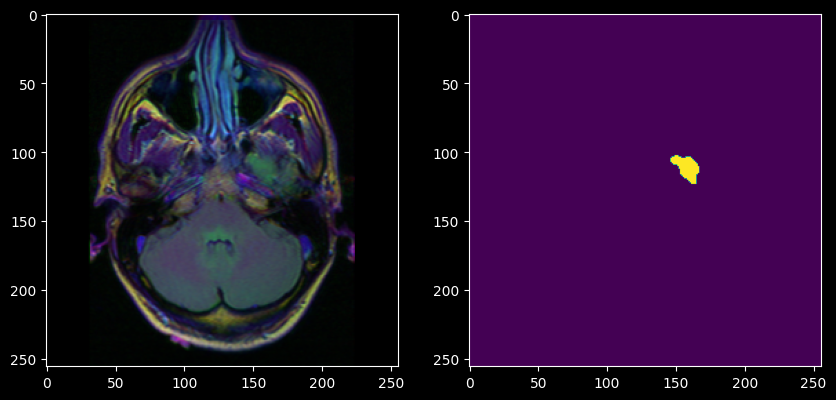

In [ ]:
img_test =[]
mask_test =[]
for i in range(len(dff)):
    idx=0
    if dff.iloc[i,3]==1:
        image = cv2.imread(dff.iloc[i, 1],1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        mask = cv2.imread(dff.iloc[i, 2], 0)
        fig,ax = plt.subplots(1,2,figsize=(10,10))
        img_test =np.array(image)
        mask_test = np.array(mask)
        ax[0].imshow(image,cmap='gray')
        ax[1].imshow(mask)
        break




# DataSet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

In [ ]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    if len(x_indices)==0:

        return [0,0,0,0]

    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)

    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox


In [ ]:
class SAMDataset(Dataset):
    def __init__(self,df,processor):
        self.df = df
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)
        ground_truth_mask = np.array(mask)
        prompt = get_bounding_box(ground_truth_mask)

        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

In [ ]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

2024-05-12 09:15:18.140167: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 09:15:18.140332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 09:15:18.404905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
!wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth

--2024-05-12 09:16:07--  https://zenodo.org/records/10689643/files/medsam_vit_b.pth
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375049145 (358M) [application/octet-stream]
Saving to: 'medsam_vit_b.pth'

medsam_vit_b.pth     17%[==>                 ]  60.86M  18.3MB/s    eta 17s    ^C


In [ ]:

train_df, val_df = train_test_split(dff, stratify=dff.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.12)
train_df = train_df.reset_index(drop=True)

Train: (3111, 4) 
Val: (393, 4) 
Test: (425, 4)


In [ ]:
train_dataset = SAMDataset(train_df,processor)
val_dataset = SAMDataset(val_df,processor)
test_dataset =SAMDataset(test_df,processor)
example = train_dataset[0]



for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


# Hyperparameters


In [ ]:
## more stable gradient estimates
batch_size = 6

lr =0.005

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,drop_last=False)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True,drop_last=False)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True,drop_last=False)

In [ ]:

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [ ]:
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
!pip install -q monai

In [ ]:
from torch.optim import Adam
import monai

# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
import matplotlib.pyplot as plt

epoch_nums = []
mean_losses = []

# Training loop
num_epochs = 1
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()

for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_loader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        epoch_losses.append(loss.item())

    # Append the epoch number and mean loss for this epoch
    epoch_nums.append(epoch + 1)
    mean_losses.append(sum(epoch_losses) / len(epoch_losses))

    print(f'EPOCH: {epoch + 1}')
    print(f'Mean loss: {mean(epoch_losses)}')

plt.figure(figsize=(8, 6))
plt.plot(epoch_nums, mean_losses)
plt.xlabel('Epoch')
plt.ylabel('Mean Loss')
plt.title('Mean Loss Over Epochs')
plt.savefig('mean_loss_plot.png')
plt.show()

#This provides .png images of analyzing different Epochs with their respective graphs of mean loss

  0%|          | 0/778 [00:00<?, ?it/s]

In [ ]:
path = "/content/drive/MyDrive"


if not os.path.exists(path):
    os.makedirs(path)

checkpoints_path = "/content/drive/MyDrive/model.pth"
torch.save(model.state_dict(), checkpoints_path)

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)

#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load(checkpoints_path))

device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)


In [ ]:
prompt = get_bounding_box(mask_test)
inputs = processor(img_test, input_boxes=[[prompt]], return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
model.eval()

# compute loss
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
print(medsam_seg.shape)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(img_test), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")


# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side

plt.show()
